In [87]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn.model_selection import train_test_split

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler
import eli5
from eli5.sklearn import PermutationImportance

# import tensorflow as tf
# from tensorflow import keras


from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel

import category_encoders as ce
import graphviz

from scipy.stats import reciprocal
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

In [88]:
def filter_years(df):
    """
    filters years 2013 and 2018 which we have to handle.
    """
    df['Date'] = pd.to_datetime(df['Date'])
    df = df[df['Date'].dt.year.isin([2013, 2018])]
    return df

weather = pd.read_csv("weatherAUS.csv")  # read csv data into pandas data frame
weather = filter_years(weather)
weather['Date'].dt.year.value_counts()

2018    17821
2013    16415
Name: Date, dtype: int64

# Aufgabe 1 Feature Engineering

In [89]:
# Spalten mit fehlender Zielvariable "RainTomorrow" rausschmeißen.
# Man könnte diese Auch als Testvariablen nehmen, dann wären diese aber nicht zufällig ausgewählt...
weather = weather[weather['RainTomorrow'].notna()]

In [90]:
# Spalten, in denen mehr als 40% der Variablen fehlen rausscheißen.
# Zeilen, in denen mehr als 50% der Variablen fehlen rausschmeißen.

weather = weather[weather.columns[weather.isnull().mean() < 0.4]]
weather = weather.loc[weather.isnull().mean(axis=1) < 0.5]

## Feate creation
creating new features

In [91]:
weather['Year'] = weather['Date'].dt.year  # get year
weather['Month'] = weather['Date'].dt.month  # get month
weather['Day'] = weather['Date'].dt.day  # get day

weather['MinMaxDiff'] = weather['MaxTemp'] - weather['MinTemp']
weather['PressureDiff'] = weather['Pressure3pm'] - weather['Pressure9am']
weather['WindSpeedDiff'] = weather['Pressure3pm'] - weather['WindSpeed9am']
weather['HumidityDiff'] = weather['Humidity3pm'] - weather['Humidity9am']

## Feature Binning

diskretisierung von Features. 

In [92]:
def encode_season(month):
    if month >= 9 and month <= 11:
        return 'Spring'
    if month == 12 or month <= 2:
        return 'Summer'
    if month >= 3 and month <= 5:
        return 'Autumn'
    if month >= 6 and month <= 8:
        return 'Winter'
    
weather['Season'] = weather['Month'].apply(encode_season)


In [93]:
# Ist quasy "Target Encoding". Nur halt manuell...

def encode_rainly_month(month):
    rainy_month = [5,6, 7,8,11]
    if month in rainy_month:
        return 1
    return 0

weather['RainyMonth'] = weather['Month'].apply(encode_rainly_month)

## Train Test split
**Important!** 

Before starting Feature Engineering one must split the dataset to ovoid test train leakage!
All Decisions in Data Engineering must be made on the Train Set only! From here, we assume that we dont have any 
knowledge about the test data.

In [94]:
#Zunächst wird noch nicht die Zielvariable "abgespalten"
#Warum? Wenn die Zielvariable noch im gleichen DataFrame ist, kann man leichter Outlier rausschmeißen.
train, test = train_test_split(weather, test_size=0.2, random_state = 0)

## Outlier detection (Optional)
**important**

this must be done after splitting. Again: We do not know anything about the test data!

**-> Verschlechtert das Ergebnis!**

Text(0, 0.5, 'WindGustSpeed')

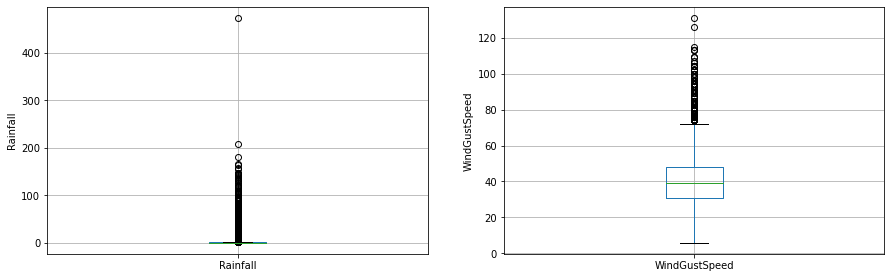

In [95]:
plt.figure(figsize=(15,10))

plt.subplot(2, 2, 1)
fig = train.boxplot(column='Rainfall')
fig.set_title('')
fig.set_ylabel('Rainfall')

plt.subplot(2, 2, 2)
fig = train.boxplot(column='WindGustSpeed')
fig.set_title('')
fig.set_ylabel('WindGustSpeed')

In [75]:
higher_lim = train['Rainfall'].quantile(0.995)
train = train[train['Rainfall'] < higher_lim]
higher_lim = train['WindGustSpeed'].quantile(0.995)
train = train[train['WindGustSpeed'] < higher_lim]

## Train Test Split part 2

hier wird jetzt die Zielvariable abgespalten

In [96]:
X_train = train.drop(['RainTomorrow'], axis=1)
y_train = train['RainTomorrow']

X_test = test.drop(['RainTomorrow'], axis=1)
y_test = test['RainTomorrow']

## Impute missing Data (Univariat)

In [97]:
# Impute values the naiive approache without considering the locations or other stuff like season

for dataset in [X_train, X_test]:

    colums_containing_nan = dataset.columns[dataset.isnull().any()]
    
    numerical_containing_nan = [col for col in colums_containing_nan if dataset[col].dtypes != 'O']
    categorial_containing_nan = [col for col in colums_containing_nan if dataset[col].dtypes == 'O']

    for col in numerical_containing_nan:
        col_median=X_train[col].median() #always use median from Train data ! Never impute based on Test Data ! we have to assume we dont know it.
        dataset[col] = dataset[col].fillna(col_median) 
        
    for col in categorial_containing_nan:
        col_most_occuring = X_train[col].mode()[0]
        dataset[col] = dataset[col].fillna(col_most_occuring)     
        

# Encoding Categorial Variables

In [98]:
X_train['RainToday'] = X_train["RainToday"].replace({'No':0, 'Yes':1})
X_test['RainToday'] = X_test["RainToday"].replace({'No':0, 'Yes':1})

y_train = y_train.replace({'No':0, 'Yes':1})
y_test = y_test.replace({'No':0, 'Yes':1})

### Target encoding

Beim target Encoding kodieren wir die Variable als Einfluss auf die Zielvariable. Wenn es also in Perth zu 20% geregnet hat, dann wird Perth mit 0.2 kodiert.

In [99]:
# Create the encoder
cat_features=['Location','WindGustDir',"WindDir9am", "WindDir3pm"]
for feature in [cat_features]:
    target_enc = ce.TargetEncoder(cols=feature)
    target_enc.fit(X_train[feature], y_train)

    # Transform the features, rename the columns with _target suffix, and join to dataframe
    X_train = X_train.join(target_enc.transform(X_train[feature]).add_suffix('_target'))
    X_test = X_test.join(target_enc.transform(X_test[feature]).add_suffix('_target'))

### One Hot Encoding

In [100]:
# apply One Hot encoding

for col in ["Season"]:
    encoded_columns = pd.get_dummies(X_train[col], prefix=col, drop_first=True)
    X_train = X_train.join(encoded_columns).drop(col, axis=1)
    
    encoded_columns = pd.get_dummies(X_test[col], prefix=col, drop_first=True)
    X_test = X_test.join(encoded_columns).drop(col, axis=1)

# Remove Features

Some features where transformed to other columns and can be removed.

In [101]:
columns_to_drop = ['Date', 'Location','WindGustDir',"WindDir9am", "WindDir3pm"]
X_train.drop(labels=columns_to_drop, axis=1, inplace=True)
X_test.drop(labels=columns_to_drop, axis=1, inplace=True)

## Scale numerical features

**Note !**
This step is not required for decision trees. Still it is recommended to do. Why?
1. We need it for Feature Selection 
2. If we change the tree to a regression or a NN, we need it.
3. It doesnt do any harm.

In [102]:
scaler = MinMaxScaler()
cols = X_train.columns

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

X_train = pd.DataFrame(X_train, columns=cols)
X_test = pd.DataFrame(np.array(X_test), columns=cols)

# Feature Selection


## The univariate way

In [83]:
# Tamara
# show correlation matrix
train = X_train
train["RainTomorrow"] = y_train.values
train.corr()

,MinTemp,MaxTemp,Rainfall,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,...,HumidityDiff,RainyMonth,Location_target,WindGustDir_target,WindDir9am_target,WindDir3pm_target,Season_Spring,Season_Summer,Season_Winter,RainTomorrow
MinTemp,1.000000,0.722267,0.046559,0.169620,0.192778,0.168783,-0.259568,-0.024287,-0.423726,-0.434395,...,0.290208,-0.410068,-0.011487,-0.227119,-0.167098,-0.208771,-0.025559,0.401770,-0.432747,0.059986
MaxTemp,0.722267,1.000000,-0.164146,0.052377,0.006944,0.035928,-0.538953,-0.546825,-0.309191,-0.412692,...,-0.047324,-0.449451,-0.277760,-0.206063,-0.228491,-0.114552,0.006145,0.428666,-0.468908,-0.189817
Rainfall,0.046559,-0.164146,1.000000,0.155977,0.100797,0.074888,0.266597,0.298665,-0.158803,-0.095594,...,0.064666,0.048445,0.121607,0.043383,0.050405,0.021282,0.003960,-0.020261,0.039909,0.298296
WindGustSpeed,0.169620,0.052377,0.155977,1.000000,0.596896,0.696054,-0.211475,-0.020430,-0.452243,-0.409406,...,0.230779,-0.086535,0.042530,0.170758,0.131892,0.161439,0.114414,0.100142,-0.085179,0.250919
WindSpeed9am,0.192778,0.006944,0.100797,0.596896,1.000000,0.511293,-0.249104,-0.007115,-0.232190,-0.176857,...,0.291944,-0.063591,0.019685,0.020039,-0.033729,0.000963,0.104050,0.045065,-0.070749,0.110805
WindSpeed3pm,0.168783,0.035928,0.074888,0.696054,0.511293,1.000000,-0.126638,0.033162,-0.290773,-0.253077,...,0.197049,-0.065385,0.078524,0.110081,0.103938,0.068693,0.104075,0.057166,-0.069445,0.106628
Humidity9am,-0.259568,-0.538953,0.266597,-0.211475,-0.249104,-0.126638,1.000000,0.679218,0.164536,0.223770,...,-0.330726,0.196375,0.347678,0.067216,0.144701,0.034547,-0.139120,-0.170469,0.222860,0.261760
Humidity3pm,-0.024287,-0.546825,0.298665,-0.020430,-0.007115,0.033162,0.679218,1.000000,-0.000453,0.094994,...,0.462237,0.160476,0.483183,0.028867,0.158285,-0.059328,-0.046748,-0.130050,0.169028,0.433683
Pressure9am,-0.423726,-0.309191,-0.158803,-0.452243,-0.232190,-0.290773,0.164536,-0.000453,1.000000,0.956540,...,-0.203007,0.221075,-0.038720,-0.178198,-0.133257,-0.173844,-0.053566,-0.322619,0.203785,-0.229535
Pressure3pm,-0.434395,-0.412692,-0.095594,-0.409406,-0.176857,-0.253077,0.223770,0.094994,0.956540,1.000000,...,-0.151355,0.219501,0.033236,-0.154353,-0.104949,-0.191382,-0.062873,-0.308520,0.202148,-0.201442


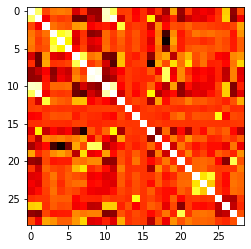

In [84]:
# Tamara
# show correlation matrix as heatmap
plt.imshow(train.corr(), cmap='hot', interpolation='nearest')
plt.show()

In [103]:
NUM_FEATURES_TO_SELECT = 5

selector = SelectKBest(f_classif, k=NUM_FEATURES_TO_SELECT)

X_new = selector.fit_transform(X_train, y_train)

selected_features = pd.DataFrame(selector.inverse_transform(X_new), 
                                 index=X_train.index, 
                                 columns=X_train.columns)

selected_columns = selected_features.columns[selected_features.var() != 0]

X_train[selected_columns].head()

,WindGustSpeed,Humidity9am,Humidity3pm,RainToday,MinMaxDiff
0,0.296,0.64,0.46,0.0,0.325733
1,0.384,0.55,0.27,1.0,0.472313
2,0.088,0.83,0.44,0.0,0.563518
3,0.232,0.47,0.22,0.0,0.530945
4,0.616,0.74,0.34,0.0,0.488599


## The multivariate way (Optional)

In [ ]:
# Regularisation strengh is set by regularization parameter C.
# Note: the lower C, the higher the regularization
logistic = LogisticRegression(C=0.01, penalty="l1", solver='liblinear', max_iter=10000, random_state=7).fit(X_train, y_train)
model = SelectFromModel(logistic, prefit=True)

X_new = model.transform(X_train)

selected_features = pd.DataFrame(model.inverse_transform(X_new), 
                                 index=X_train.index,
                                 columns=X_train.columns)

# Dropped columns have values of all 0s, keep other columns 
selected_columns = selected_features.columns[selected_features.var() != 0]
selected_columns

In [ ]:
# getting accuracy for a logistic regression model 
logistic = LogisticRegression().fit(X_train[selected_columns], y_train)

test_predictions = logistic.predict(X_test[selected_columns]).round().astype(int)
print(accuracy_score(y_test, test_predictions))
mean_absolute_error(y_test, test_predictions)

# Aufgabe 2 Entscheidungsbäume

In [86]:
model = tree.DecisionTreeClassifier()
model.fit(X_train, y_train)

test_predictions = model.predict(X_test).round().astype(int)
print(accuracy_score(y_test, test_predictions))
mean_absolute_error(y_test, test_predictions)

ValueError: Number of features of the model must match the input. Model n_features is 29 and input n_features is 28 

## Baseline

this is what we got from the beginnnig:
    
0.8435955056179776

0.15640449438202247

# Visualization

In [ ]:
fig, ax = plt.subplots(figsize = (20,10))
tree.plot_tree(model, ax=ax,
              feature_names=selected_columns,
              filled = True,
              rounded = True,
              precision =2,
              fontsize = 10,
               class_names=["no Rain", "Rain"]
              );

In [ ]:
tree_graph = tree.export_graphviz(model, out_file=None, feature_names=selected_columns, class_names=["no Rain", "Rain"])
graphviz.Source(tree_graph)

In [ ]:
# Tamara
# change max_depth
model1 = tree.DecisionTreeClassifier(max_depth=5)

model1.fit(X_train[selected_columns], y_train)

In [ ]:
# Tamara
test_predictions1 = model1.predict(X_test[selected_columns]).round().astype(int)
print(accuracy_score(y_test, test_predictions1))
mean_absolute_error(y_test, test_predictions1)

In [ ]:
# Tamara
fig, ax = plt.subplots(figsize = (20,10))
tree.plot_tree(model1, ax=ax,
               feature_names=selected_columns,
               class_names= ["Rain", "no Rain"],
               filled = True,
               rounded = True,
               precision = 2,
               fontsize = 10);

In [ ]:
# Tamara
# change min_impurity_increase
model2 = tree.DecisionTreeClassifier(min_impurity_decrease=0.003)

model2.fit(X_train[selected_columns], y_train)

# Tamara
test_predictions2 = model2.predict(X_test[selected_columns]).round().astype(int)
print(accuracy_score(y_test, test_predictions2))
mean_absolute_error(y_test, test_predictions2)

In [ ]:
# Tamara
fig, ax = plt.subplots(figsize = (20,10))
tree.plot_tree(model2, ax=ax,
               feature_names=selected_columns,
               class_names= ["Rain", "no Rain"],
               filled = True,
               rounded = True,
               precision = 2,
               fontsize = 10);

In [ ]:
# Tamara
# change max_leaf_nodes
model3 = tree.DecisionTreeClassifier(criterion="entropy", max_depth=5)

model3.fit(X_train[selected_columns], y_train)

# Tamara
test_predictions3 = model3.predict(X_test[selected_columns]).round().astype(int)
print(accuracy_score(y_test, test_predictions3))
mean_absolute_error(y_test, test_predictions3)

In [ ]:
# Tamara
fig, ax = plt.subplots(figsize = (20,10))
tree.plot_tree(model3, ax=ax,
               feature_names=selected_columns,
               class_names= ["Rain", "no Rain"],
               filled = True,
               rounded = True,
               precision = 2,
               fontsize = 10);

## Null accuracy 
Whats the accuracy of a model, which just predicts the most common class.

In [ ]:
y_test.value_counts()

In [ ]:
print(5272/(5272+1403))

## Analysis

In [ ]:
perm = PermutationImportance(model, random_state=1).fit(X_test, y_test)
eli5.show_weights(perm, feature_names = X_test.columns.tolist())

## cost complexity pruning
Führe mit mind 3 Bäumen unterschiedlicher Tiefe aus Aufgabenteil c) ein Minimal Cost Complexity Pruning durch. Wie verändern dich die Bäume bei Variation des Prunings? Welche Auswirkung auf die Modellgüte hat das?

In [138]:
# Tamara
model = tree.DecisionTreeClassifier()
path = model.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

In [134]:
path

{'ccp_alphas': array([0.00000000e+00, 1.86854200e-05, 2.14007509e-05, ...,
        4.37731302e-03, 1.16379402e-02, 5.63199463e-02]),
 'impurities': array([0.00000000e+00, 7.47416798e-05, 2.24546936e-04, ...,
        2.60074303e-01, 2.71712243e-01, 3.28032190e-01])}

Text(0.5, 1.0, 'Total Impurity vs effective alpha for training set')

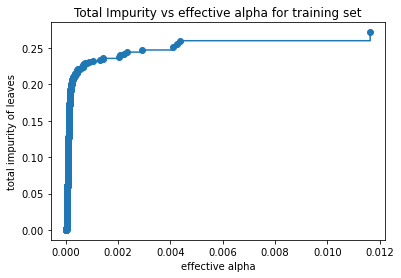

In [139]:
#Tamara
fig, ax = plt.subplots()
ax.plot(ccp_alphas[:-1], impurities[:-1], marker='o', drawstyle="steps-post")
ax.set_xlabel("effective alpha")
ax.set_ylabel("total impurity of leaves")
ax.set_title("Total Impurity vs effective alpha for training set")

In [142]:
#Tamara
model = tree.DecisionTreeClassifier(ccp_alpha=0.0005)
model.fit(X_train[selected_columns], y_train)

test_predictions = model.predict(X_test[selected_columns]).round().astype(int)
print(accuracy_score(y_test, test_predictions))
mean_absolute_error(y_test, test_predictions)

0.8442278860569715


0.15577211394302848

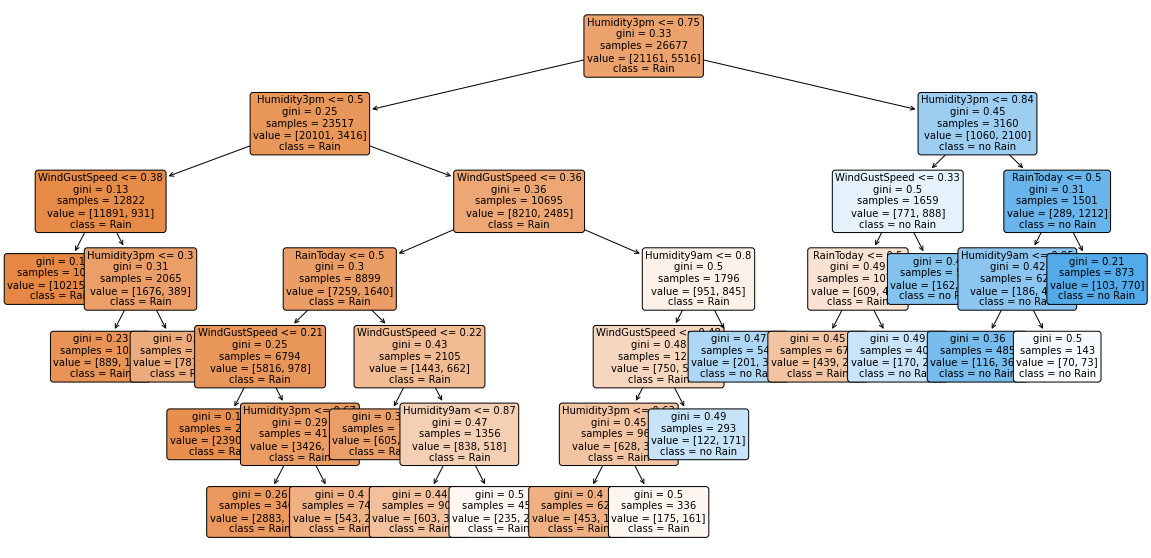

In [143]:
# Tamara
fig, ax = plt.subplots(figsize = (20,10))
tree.plot_tree(model, ax=ax,
               feature_names=selected_columns,
               class_names= ["Rain", "no Rain"],
               filled = True,
               rounded = True,
               precision = 2,
               fontsize = 10);

# Booklet 2 Neuronale Netze Aufgabe 2

### Using RandomSearch to find the perfect Hyperparameter combination

In [ ]:
#wrap function around model creation so it can be used for grid search
def build_model(n_hidden = 1, n_neurons=30, learning_rate=0.1, activation_function='relu', dropout_prop=0.25):
    model = keras.models.Sequential()
    model.add(keras.layers.Dense(2, activation='relu'))
    for layer in range(n_hidden):
        model.add(keras.layers.Dense(n_neurons, activation=activation_function))
    model.add(keras.layers.Dense(1))
    model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=learning_rate),
                  loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                  metrics=['accuracy'])
    model.add(keras.layers.Dropout(dropout_prop))
    return model

nn = keras.wrappers.scikit_learn.KerasClassifier(build_model)

In [ ]:
params = {
    'n_hidden': [0,1,2,3,4],
    'n_neurons': [1,3,5,10,20,50,100],
    'learning_rate': [0.1, 0.05, 0.01],
    'activation_function': ['relu', 'sigmoid', 'elu'],
    'dropout_prop': [0, 0.25, 0.5] 
}

In [ ]:
random_search = RandomizedSearchCV(nn, params, n_iter=20)
random_search.fit(X_train.values, 
                  y_train.values,
                  validation_data=(X_test.values, y_test.values),
                  callbacks=[keras.callbacks.EarlyStopping(patience=6)],
                  batch_size=32,
                  epochs=100
                 )

In [ ]:
random_search.best_params_

## Building the winner Model

In [ ]:
#dont need this anymore...
train_dataset = tf.data.Dataset.from_tensor_slices((X_train.values, y_train.values))
train_dataset = train_dataset.shuffle(len(X_train)).batch(32)

test_dataset = tf.data.Dataset.from_tensor_slices((X_test.values, y_test.values))
test_dataset = test_dataset.shuffle(len(X_test)).batch(len(X_test))

In [ ]:
nn = keras.models.Sequential()
nn.add(keras.layers.Dense(2, activation='elu'))
for layer in range(4):
        nn.add(keras.layers.Dense(3, activation='elu'))
nn.add(keras.layers.Dense(1))
    
nn.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.1),
           loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
           metrics=['accuracy'])

In [ ]:
nn.fit(train_dataset,
       validation_steps=1,
       validation_data=test_dataset,
       batch_size=32,
       callbacks=[keras.callbacks.EarlyStopping(patience=6)],
       epochs=50)

# Booklet 3 Ensemblemethoden

In [ ]:
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.model_selection import GridSearchCV

### Bagging

In [ ]:
# Ist das hier nicht im Prinzip das Gleiche wie ein Random Forest mit splitter="random"?
bagging_classifier = BaggingClassifier( 
    base_estimator=DecisionTreeClassifier(criterion='gini'), 
    bootstrap=True, #replace training samples
    n_jobs=-1, #use all available cores
    random_state=42
)

bagging_classifier.fit(X_train, y_train)

test_predictions = bagging_classifier.predict(X_test).round().astype(int)
print(accuracy_score(y_test, test_predictions))
mean_absolute_error(y_test, test_predictions)

### Random Forest

In [ ]:
random_forest_classifier = RandomForestClassifier(  
    bootstrap=True, #replace training samples
    random_state=42,
    n_jobs=-1 #use all available cores
)

random_forest_classifier.fit(X_train, y_train)

test_predictions = random_forest_classifier.predict(X_test).round().astype(int)
print(accuracy_score(y_test, test_predictions))
mean_absolute_error(y_test, test_predictions)

In [ ]:
# Feature importances with random forest
for name, score in zip(X_train.columns, random_forest_classifier.feature_importances_):
    print(name, score)

### Adaboost

In [ ]:
adaboost_classifier = AdaBoostClassifier(
    base_estimator=DecisionTreeClassifier(criterion='gini', max_depth=5),
    n_estimators=50,
    random_state=42
)

adaboost_classifier.fit(X_train, y_train)

test_predictions = adaboost_classifier.predict(X_test).round().astype(int)
print(accuracy_score(y_test, test_predictions))
mean_absolute_error(y_test, test_predictions)

### Grid Search

In [ ]:
params_bagging_adaboost = [{'n_estimators': [10,50,100]},
                           {"base_estimator__criterion": ["gini", "entropy"]},
                           {"base_estimator__max_depth": [3,5,10]},
                           {"base_estimator__min_samples_split": [2,5,10]},#The minimum number of samples required to split an internal node:
                           {"base_estimator__min_samples_leaf": [1,2,5,10]},#The minimum number of samples required to be at a leaf node
                           {"base_estimator__min_weight_fraction_leaf": [0, 0.2, 0.4, 0.5]},#The minimum weighted fraction of the sum total of weights (of all the input samples) required to be at a leaf node. 
                           {"base_estimator__max_features": [1,2,10,15,None]},
                           {"base_estimator__max_leaf_nodes": [None,2,5,10,100]},
                           {"base_estimator__min_impurity_decrease": [0.1, 0.2, 0.5, 0.8, 1, 2, 3]},
                           {"base_estimator__min_impurity_split": [0.1, 0.2, 0.5, 0.8, 1, 2, 3]} #dericated option
                          ]

params_random_forest = {
    'n_estimators': [50,100],
    "criterion": ["gini", "entropy"],
#    "base_estimator__max_depth": [3,5,10],
#    "base_estimator__min_samples_split": [2,5,10],
#    "base_estimator__min_samples_leaf": [1,2,5]
}

params_tree = {
    "criterion": ["gini", "entropy"],
    "max_depth": [1,3,5,10,20,50]
}

In [ ]:
#looping through grid ourselfes for better interpretation of outputs.
for param in params_bagging_adaboost:
    bagging_gs = GridSearchCV(bagging_classifier, param, cv=10)
    bagging_gs.fit(X_train, y_train)
    print(param)
    print(bagging_gs.best_params_)
    print(bagging_gs.best_score_)
    print(" ")

### Old to be deleted soon

In [ ]:
bagging_gs = GridSearchCV(bagging_classifier, params_bagging_adaboost, cv=10)
random_forest_gs =  GridSearchCV(random_forest_classifier, params_random_forest, cv=10)
adaboost_gs =  GridSearchCV(adaboost_classifier, params_bagging_adaboost, cv=10)
tree_gs = GridSearchCV(tree.DecisionTreeClassifier(), params_tree, cv=10)

tree_gs.fit(X_train, y_train)
tree_gs.best_params_

In [ ]:
random_forest_gs.fit(X_train, y_train)
random_forest_gs.best_params_

In [ ]:
bagging_gs.fit(X_train, y_train)
bagging_gs.best_score_

### Visualisation of GridSearch results

In [ ]:
results = bagging_gs.cv_results_
results

In [ ]:
# plot wie hier:
# TODO:
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_multi_metric_evaluation.html#sphx-glr-auto-examples-model-selection-plot-multi-metric-evaluation-py

# SVM Booklet Teil 4
**Note**: Hab keine Ahnung was hier genau passiert. Aber es funktioniert vom Code her.
### Parameters of SVM
- C: Sets the margin. Kleines C führt zu ner Große margin. Große Margin regularisiert mehr, also tritt eher underfitting auf. Großes C overfittetet eher.

In [ ]:
from sklearn.svm import SVC

### linear Kernel

In [ ]:
svm_linear = SVC(kernel="linear", C=1)
svm_linear.fit(X_train, y_train)

test_predictions = svm_linear.predict(X_test).round().astype(int)
print(accuracy_score(y_test, test_predictions))
mean_absolute_error(y_test, test_predictions)

### Polynominal Kernel

In [ ]:
svm_poly = SVC(kernel="poly", degree=5,C=1)
svm_poly.fit(X_train, y_train)

test_predictions = svm_poly.predict(X_test).round().astype(int)
print(accuracy_score(y_test, test_predictions))
mean_absolute_error(y_test, test_predictions)

### Gaussian RBF Kernel

In [ ]:
svm_rbf = SVC(kernel="rbf", gamma=5, C=0.01)
svm_rbf.fit(X_train, y_train)

test_predictions = svm_rbf.predict(X_test).round().astype(int)
print(accuracy_score(y_test, test_predictions))
mean_absolute_error(y_test, test_predictions)

### Sigmoid Kernel

In [ ]:
svm_sigmoid = SVC(kernel="sigmoid", C=0.01)
svm_sigmoid.fit(X_train, y_train)

test_predictions = svm_sigmoid.predict(X_test).round().astype(int)
print(accuracy_score(y_test, test_predictions))
mean_absolute_error(y_test, test_predictions)

### precomputed Kernel

In [ ]:
gram_train = np.dot(X_train, X_train.T)
gram_test = np.dot(X_test, X_train.T)

svm_precomputed = SVC(kernel="precomputed", C=0.01)

svm_precomputed.fit(gram_train, y_train)

test_predictions = svm_precomputed.predict(gram_test).round().astype(int)
print(accuracy_score(y_test, test_predictions))
mean_absolute_error(y_test, test_predictions)